Comencemos por importar las librerías necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

Ahora hagamos una función que genere la malla. Hagamos la malla con cuadrados del mismo tamaño y enumeremos los nodos siendo el primero el de abajo a la izquierda y luego en sentido antihorario

In [3]:
def GenerarMalla(N):
    h = 1.0/N
    coords = []
    for j in range(N+1):
        for i in range(N+1):
            coords.append([i * h, j * h])
    coords = np.array(coords)

    IEN = []
    for j in range(N):
        for i in range(N):
            n0 = j*(N+1) + i
            n1 = j*(N+1) + i + 1
            n2 = j*(N+1) + i + 1 + (N + 1)
            n3 = j*(N+1) + i + (N + 1)
            IEN.append([n0, n1, n2, n3])
    IEN = np.array(IEN)

    return coords, IEN

Imprimamos la malla para ver que tal resultó

In [583]:
N = 2
coords, IEN = GenerarMalla(N)
print(coords)
print(IEN)

[[0.  0. ]
 [0.5 0. ]
 [1.  0. ]
 [0.  0.5]
 [0.5 0.5]
 [1.  0.5]
 [0.  1. ]
 [0.5 1. ]
 [1.  1. ]]
[[0 1 4 3]
 [1 2 5 4]
 [3 4 7 6]
 [4 5 8 7]]


Se ve bien, grafiquémosla para validar los resultados

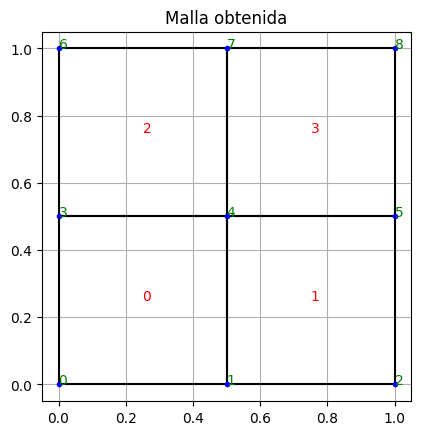

In [584]:
def GraficarMalla(coords, IEN):
    _, ax = plt.subplots()
    for id in range(len(IEN)):
        elem = IEN[id]
        elemplot = np.append(elem, elem[0])
        poly = coords[elemplot]
        ax.plot(poly[:, 0], poly[:, 1], 'k-')

        cx = np.mean(coords[elem, 0])
        cy = np.mean(coords[elem, 1])
        ax.text(cx, cy, str(id), color='red')

    for id in range(len(coords)):
        (x, y) = coords[id]
        ax.plot(x, y, 'b.')
        ax.text(x, y, str(id), color='green')

    ax.set_aspect('equal')
    ax.set_title("Malla obtenida")
    ax.grid(True)
    plt.show()

GraficarMalla(coords, IEN)

Los resultados son los esperados, así que prosigamos con la implementación.

Consideremos la siguiente base (súper clásica) para el cuadrado $[0, 1] \times [0, 1]$
$$\varphi_0(x, y) = (1-x)(1-y), \quad \varphi_1(x, y) = x(1-y), \quad \varphi_2(x, y) = xy, \quad \varphi_3(x, y) = (1-x)y$$

Y sus derivadas corresponden respectivamente a
$$\nabla \varphi_0(x, y) = \begin{bmatrix} y-1 \\ x-1 \end{bmatrix}, \quad \nabla \varphi_1(x, y) = \begin{bmatrix} 1-y \\ -x \end{bmatrix}, \quad \nabla \varphi_2(x, y) = \begin{bmatrix} y \\ x \end{bmatrix}, \quad \nabla \varphi_3(x, y) = \begin{bmatrix} -y \\ 1-x \end{bmatrix}$$

Entonces, para el elemento $K$ las matrices asociadas corresponden a .

Para el término $-\Delta u$
$$D_{ij}^K = \int_K \mu \nabla \varphi_j \cdot \nabla \varphi_i \, dx$$
Para el término $b\cdot\nabla u$
$$A_{ij}^K = \int_K b\cdot \nabla \varphi_j \varphi_i \, dx$$
Y para el término $u$
$$R_{ij}^K = \int_K c \varphi_j \varphi_i \, dx$$

Para la regla de cuadratura consideremos la de Gauss-Legendre ya que nos permite calcular la integral de polinomios de forma exacta. Y entonces tenemos que vamos a evaluar en los puntos.

Para la cuadratura voy a implementar una función que me permita hacer la cuadratura global y local para cada elemento, y poder decidir cuantos puntos por lado consideraremos en la cuadratura.

In [4]:
def GlobalCuadrature(n = 5):
    x1, w1 = np.polynomial.legendre.leggauss(n)
    
    x = []
    y = []
    w = []
    
    for i in range(n):
        for j in range(n):
            x.append(0.5*(x1[i] + 1))
            y.append(0.5*(x1[j] + 1))
            w.append(0.25*w1[i]*w1[j])
            
    return x, y, w

def LocalCuadrature(x, y, coord):
    h = (coord[2][0] - coord[0][0])
    xl = [x[i]*h + coord[0][0] for i in range(len(x))]
    yl = [y[i]*h + coord[0][1] for i in range(len(y))]
    return xl, yl

Ahora implementemos las funciones $\varphi$ y $\nabla \varphi$ y el cálculo de las matrices asociadas a $\Delta u, b \cdot \nabla u, cu$ respectivamente usando las cuadraturas mencionadas anteriormente. El resultado se puede ver a continuación.

In [5]:
def varphi(i, x, y):
    if i == 0:
        return (1-x)*(1-y)
    if i == 1:
        return x*(1-y)
    if i == 2:
        return x*y
    if i == 3:
        return (1-x)*y
    
def gradvarphi(i, x, y):
    if i == 0:
        return np.array([y-1, x-1])
    if i == 1:
        return np.array([1-y, -x])
    if i == 2:
        return np.array([y, x])
    if i == 3:
        return np.array([-y, 1-x])
    
def getD(mu, coord):
    x, y, w = GlobalCuadrature(2)
    xl, yl = LocalCuadrature(x, y, coord)
    D = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            D[j, i] = sum(w[r]*mu(xl[r], yl[r])*np.dot(gradvarphi(i, x[r], y[r]), gradvarphi(j, x[r], y[r])) for r in range(len(x)))
    return D

def getA(b, coord):
    x, y, w = GlobalCuadrature(3)
    xl, yl = LocalCuadrature(x, y, coord)
    A = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            A[j, i] = sum(w[r]*np.dot(b(xl[r], yl[r]), gradvarphi(i, x[r], y[r]))*varphi(j, x[r], y[r]) for r in range(len(x)))
    return A

def getR(c, coord):
    x, y, w = GlobalCuadrature(4)
    xl, yl = LocalCuadrature(x, y, coord)
    R = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            R[j, i] = sum(w[r]*c(xl[r], yl[r])*varphi(i, x[r], y[r])*varphi(j, x[r], y[r]) for r in range(len(x)))
    return R

Validemos los resultados anteriores haciendo las integrales de forma simbólica con sympy. Para esto voy a considerar hacerlo con los $\mu, b, c$ que usaré más adelante para validar la solución total

In [11]:
def mu(x, y):
    return 1.0

def b(x, y):
    return np.array([0, 0])
    return np.array([x+2*y, 2*x+y])

def c(x, y):
    return 0
    return x*y

def validar():
    x, y = sp.symbols('x y')

    varphi = [(1 - x)*(1 - y), x*(1 - y), x*y, (1 - x)*y]
    gradvarphi = [[sp.diff(phi, x), sp.diff(phi, y)] for phi in varphi]
    
    coord = [[0, 0], [1.0, 0], [1.0, 1.0], [0, 1.0]]
    
    D = getD(mu, coord)
    A = getA(b, coord)
    R = getR(c, coord)

    for i in range(4):
        for j in range(4):
            intD = 10*(gradvarphi[i][0]*gradvarphi[j][0] + gradvarphi[i][1]*gradvarphi[j][1])
            Dji = float(sp.integrate(sp.integrate(intD, (x, 0, 1)), (y, 0, 1)))
            if abs(Dji - D[j, i]) > 1e-10:
                print(f"Problemas en D[{j}, {i}]")
                
            intA = ((x + 2*y)*gradvarphi[i][0] + (2*x + y)*gradvarphi[i][1])*varphi[j]
            Aji = float(sp.integrate(sp.integrate(intA, (x, 0, 1)), (y, 0, 1)))
            if abs(Aji - A[j, i]) > 1e-10:
                print(f"Problemas en A[{j}, {i}]")
            
            intR = x*y*varphi[i]*varphi[j]
            Rji = float(sp.integrate(sp.integrate(intR, (x, 0, 1)), (y, 0, 1)))
            if abs(Rji - R[j, i]) > 1e-10:
                print(f"Problemas en R[{j}, {i}]")

validar()


Problemas en D[0, 0]
Problemas en A[0, 0]
Problemas en R[0, 0]
Problemas en D[1, 0]
Problemas en A[1, 0]
Problemas en R[1, 0]
Problemas en D[2, 0]
Problemas en A[2, 0]
Problemas en R[2, 0]
Problemas en D[3, 0]
Problemas en A[3, 0]
Problemas en R[3, 0]
Problemas en D[0, 1]
Problemas en A[0, 1]
Problemas en R[0, 1]
Problemas en D[1, 1]
Problemas en A[1, 1]
Problemas en R[1, 1]
Problemas en D[2, 1]
Problemas en A[2, 1]
Problemas en R[2, 1]
Problemas en D[3, 1]
Problemas en A[3, 1]
Problemas en R[3, 1]
Problemas en D[0, 2]
Problemas en A[0, 2]
Problemas en R[0, 2]
Problemas en D[1, 2]
Problemas en A[1, 2]
Problemas en R[1, 2]
Problemas en D[2, 2]
Problemas en A[2, 2]
Problemas en R[2, 2]
Problemas en D[3, 2]
Problemas en A[3, 2]
Problemas en R[3, 2]
Problemas en D[0, 3]
Problemas en A[0, 3]
Problemas en R[0, 3]
Problemas en D[1, 3]
Problemas en A[1, 3]
Problemas en R[1, 3]
Problemas en D[2, 3]
Problemas en A[2, 3]
Problemas en R[2, 3]
Problemas en D[3, 3]
Problemas en A[3, 3]
Problemas en 

Como no imprimió nada significa que las integrales han sido calculadas correctamente.

Para el lado derecho en el elemento $K$ sabemos que
$$f_i^K = L(\varphi_i) = \int_K f\varphi_i \,dx$$
Y entonces implementémoslo de forma análoga a los anteriores

In [7]:
def getF(f, coord):
    x, y, w = GlobalCuadrature(6)
    xl, yl = LocalCuadrature(x, y, coord)
    F = np.zeros((4))
    for i in range(4):
        F[i] = sum(w[r]*f(xl[r], yl[r])*varphi(i, x[r], y[r]) for r in range(len(x)))
    return F

In [8]:
def getProblem(mu, b, c, f, N):
    coords, IEN = GenerarMalla(N)
    n = len(coords)
    A = lil_matrix((n, n))
    F = np.zeros(n)
    h = (1/N)

    for e in range(len(IEN)):
        nodos = IEN[e]
        coord = coords[nodos]

        Al = (getD(mu, coord) + h*getA(b, coord) + h**2*getR(c, coord))
        Fl = h**2*getF(f, coord)
        
        for i in range(4):
            F[nodos[i]] += Fl[i]
            for j in range(4):
                A[nodos[i], nodos[j]] += Al[i, j]

    return A, F, coords, IEN

In [9]:
def f(x, y):
    return 0

In [12]:
A, F, coords, IEN = getProblem(mu, b, c, f, 10)

In [13]:
print(np.linalg.cond(A.toarray()))

1.232043950054795e+16


En la teoría debieramos encontrar una función $G$ que cumpla la condición de borde, y entonces consideramos $u = u_0 + G$ y solo resolvemos $u_0$ con condiciones de Dirichlet homogéneas. Sin embargo, en la práctica podemos simplemente ajustar las matriz y el lado derecho, y esto funciona bien puesto que la formulación débil es lineal. Supongamos quisieramos imponer el valor $g$ en el nodo $i$, entonces podemos dejar la fila $i$-ésima nula salvo un $1$ en la $i$-ésima columna, y en el lado derecho dejamos $g$ en la $i$-ésima entrada. Así, la única solución posible para dicho nodo es que valga $g$. Esto lo implementamos a continuación.

In [662]:
def setDirichlet(A, F, coords):
    for i in range(len(coords)):
        x = coords[i][0]
        if abs(x - 1.0) < 1e-6:
            A.rows[i] = [i]
            A.data[i] = [1.0]
            F[i] = 1
    return A, F

Ahora consideremos probar nuestra implementación usando la solución manufacturada
$$u(x, y) = x^2(1-x)y^2(1-y)^2 + 1$$
Calculemos sus derivadas
$$\nabla u(x, y) = \begin{bmatrix} (2x-3x^2)y^2(1-y)^2 \\ x^2(1-x)(2y-6y^2+4y^3) \end{bmatrix}$$
Y entonces
$$\Delta u(x, y) = (2-6x)y^2(1-y)^2 + x^2(1-x)(2 - 12y + 12y^2)$$
Notemos además que
$$u(1, y) = 1, \quad \frac{\partial u}{\partial x}(0, y) = 0, \quad \frac{\partial u}{\partial x}(x, 0) = 0, \quad \frac{\partial u}{\partial x}(x, 1) = 0$$
Y entonces cumple las condiciones de borde, por lo que es una solución valida. La función $f$ del lado derecho es fácil encontrarla sabiendo estas cantidades que ya calculé y multiplicando por las funciones $\mu, b, c$ que definimos más arriba. No lo voy a dejar aquí por temas de espacio pero se puede ver la forma exacta en la implementación de abajo.

Para calcular el error de apoximación usé que la norma se puede dividir por elementos y la integral en cada elemento la calculé con la cuadratura que habíamos implementado anteriormente. Además, para obtener la solución en cada punto de la cuadratura hice una interpolación lineal con respecto a los valores de los vértices.


In [663]:
def uexact(x, y):
    return x**2*(1-x)*y**2*(1-y)**2 + 1

def f(x, y):
    d = -10*(2-6*x)*y**2*(1-y)**2 - 10*x**2*(1-x)*(2-12*y+12*y**2)
    a = (x+2*y)*(2*x-3*x**2)*y**2*(1-y)**2 + (2*x+y)*x**2*(1-x)*(2*y-6*y**2+4*y**3)
    r = x**3*(1-x)*y**3*(1-y)**2 + x*y
    return d + a + r

def Interpolate(u, x, y):
    usol = (1-x)*(u[0] + u[3])
    usol += x*(u[1] + u[2])
    usol += (1-y)*(u[0] + u[1])
    usol += y*(u[2] + u[3])
    return usol/4

def Error(u, IEN, coords):
    error = 0
    J = 1/len(coords)
    for nodo in IEN:
        coord = coords[nodo]
        x, y, w = GlobalCuadrature(4)
        xl, yl = LocalCuadrature(x, y, coord)
        sum = 0
        for r in range(len(x)):
            usol = Interpolate(u[nodo], x[r], y[r])
            sum += w[r]*(uexact(xl[r], yl[r]) - usol)**2
        error += sum*J
    return error

In [ ]:
getProblem()

Y ahora tenemos todo listo para hacer nuestro experimento

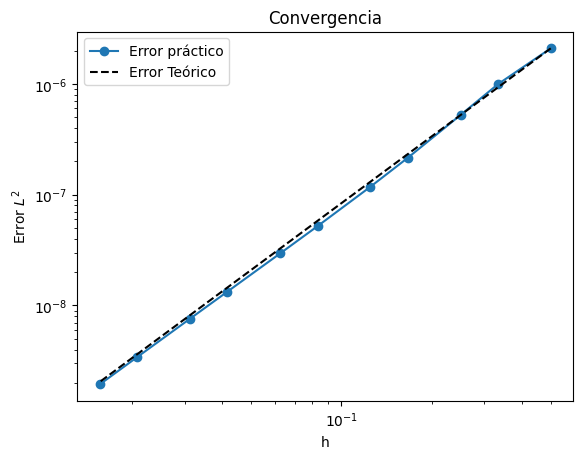

In [ ]:
Ns = [2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64]
errors = []
hs = []

for N in Ns:
    h = 1/N
    hs.append(h)
    A, F, coords, IEN = getProblem(mu, b, c, f, N)
    A, F = setDirichlet(A, F, coords)
    u = spsolve(csr_matrix(A), F)
    error = Error(u, IEN, coords)
    errors.append(error)

plt.loglog(hs, errors, 'o-', label="Error práctico")
plt.loglog(hs, [errors[0]*(h/hs[0])**2 for h in hs], 'k--', label="Error Teórico")
plt.xlabel("h")
plt.ylabel("Error $L^2$")
plt.title("Convergencia")
plt.legend()
plt.show()

Podemos ver que la convergencia es del orden de $O(h^2)$, lo que se espera de la teoría para el error en la norma $L^2$ para el método de los elementos finitos usando una base de polinomios lineales.

Además, los errores obtenidos son bajos, y eso valida que el algoritmo está funcionando correctamente.